In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Our task is to predict the rating for a user/movie pair, with the idea that if we had a model that's good at this task then we could predict how a user would rate movies they haven't seen yet and recommend movies with the highest predicted rating.

In [ ]:
ratings = pd.read_csv('https://github.com/sparsh-ai/reco-data/blob/master/MovieLens_LatestSmall_ratings.csv?raw=true')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies = pd.read_csv('https://github.com/sparsh-ai/reco-data/blob/master/MovieLens_LatestSmall_movies.csv?raw=true')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


To get a better sense of what the data looks like, we can turn it into a table by selecting the top 15 users/movies from the data and joining them together. The result shows how each of the top users rated each of the top movies.

In [ ]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


To build our first collaborative filtering model, we need to take care of a few things first. The user/movie fields are currently non-sequential integers representing some unique ID for that entity. We need them to be sequential starting at zero to use for modeling (you'll see why later). We can use scikit-learn's LabelEncoder class to transform the fields. We'll also create variables with the total number of unique users and movies in the data, as well as the min and max ratings present in the data, for reasons that will become apparent shortly.

In [ ]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

Create a traditional (X, y) pairing of data and label, then split the data into training and test data sets.

In [ ]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 2), (10084, 2), (90752,), (10084,))

Another constant we'll need for the model is the number of factors per user/movie. This number can be whatever we want, however for the collaborative filtering model it does need to be the same size for both users and movies. The famous prof. Jeremy Howard said he played around with different numbers and 50 seemed to work best so we'll go with that.

Finally, we need to turn users and movies into separate arrays in the training and test data. This is because in Keras they'll each be defined as distinct inputs, and the way Keras works is each input needs to be fed in as its own array.

In [ ]:
n_factors = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

Now we get to the model itself. The main idea here is we're going to use embeddings to represent each user and each movie in the data. These embeddings will be vectors (of size n_factors) that start out as random numbers but are fit by the model to capture the essential qualities of each user/movie. We can accomplish this by computing the dot product between a user vector and a movie vector to get a predicted rating. The code is fairly simple, there isn't even a traditional neural network layer or activation involved. I stuck some regularization on the embedding layers and used a different initializer but even that probably isn't necessary. Notice that this is where we need the number of unique users and movies, since those are required to define the size of each embedding matrix.

In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Add, Activation, Lambda
from tensorflow.keras.layers import Concatenate, Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy

In [83]:
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

This is kind of a neat example of how flexible and powerful modern computation frameworks like Keras and PyTorch are. Even though these are billed as deep learning libraries, they have the building blocks to quickly create any computation graph you want and get automatic differentiation essentially for free. Below you can see that all of the parameters are in the embedding layers, we don't have any traditional neural net components at all.

In [84]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
______________________________________________________________________________________________

Let's go ahead and train this for a few epochs and see what we get.

In [85]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
1418/1418 [==============================] - 7s 4ms/step - loss: 0.2957 - val_loss: 9.6451
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.0775 - val_loss: 9.3903
Epoch 3/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.0559 - val_loss: 9.3631
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.0429 - val_loss: 9.4215
Epoch 5/5
1418/1418 [==============================] - 6s 5ms/step - loss: 0.0341 - val_loss: 9.4183


Not bad for a first try. We can make some improvements though. The first thing we can do is add a "bias" to each embedding. The concept is similar to the bias in a fully-connected layer or the intercept in a linear model. It just provides an extra degree of freedom. We can implement this idea using new embedding layers with a vector length of one. The bias embeddings get added to the result of the dot product.

The second improvement we can make is running the output of the dot product through a sigmoid layer and then scaling the result using the min and max ratings in the data. This is a neat technique that introduces a non-linearity into the output and results in a modest performance bump.

I also refactored the code a bit by pulling out the embedding layer and reshape operation into a separate class.

In [ ]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)

    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

The model summary shows the new graph. Notice the additional embedding layers with parameter numbers equal to the unique user and movie counts.

In [ ]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        30500       input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 50)        486200      input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
1418/1418 [==============================] - 9s 5ms/step - loss: 1.4183 - val_loss: 0.8540
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7206 - val_loss: 0.7518
Epoch 3/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.5285 - val_loss: 0.7338
Epoch 4/5
1418/1418 [==============================] - 6s 5ms/step - loss: 0.3940 - val_loss: 0.7388
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.2986 - val_loss: 0.7557


Those two additions to the model resulted in a pretty sizable improvement. Validation error is now down to ~0.76 which is about as good as what Jeremy got (and I believe close to SOTA for this data set).

That pretty much covers the conventional approach to solving this problem, but there's another way we can tackle this. Instead of taking the dot product of the embedding vectors, what if we just concatenated the embeddings together and stuck a fully-connected layer on top of them? It's still not technically "deep" but it would at least be a neural network! To modify the code, we can remove the bias embeddings from V2 and do a concat on the embedding layers instead. Then we can add some dropout, insert a dense layer, and stick some dropout on the dense layer as well. Finally, we'll run it through a single-unit dense layer to keep the sigmoid trick at the end.

In [ ]:
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

Most of the parameters are still in the embedding layers, but we have some added learning capability from the dense layers.

In [ ]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        30500       input_7[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 50)        486200      input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
1418/1418 [==============================] - 10s 5ms/step - loss: 1.0527 - val_loss: 0.7907
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.7608 - val_loss: 0.7810
Epoch 3/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.7106 - val_loss: 0.7764
Epoch 4/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6981 - val_loss: 0.7828
Epoch 5/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6815 - val_loss: 0.7868


Without doing any tuning at all we still managed to get a result that's pretty close to the best performance we saw with the traditional approach. This technique has the added benefit that we can easily incorporate additional features into the model. For instance, we could create some date features from the timestamp or throw in the movie genres as a new embedding layer. We could tune the size of the movie and user embeddings independently since they no longer need to match. Lots of possibilities here.

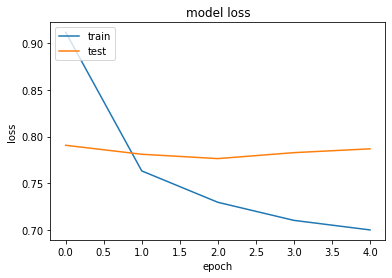

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [88]:
df = ratings.copy()

user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [90]:
EMBEDDING_SIZE = 50

class RecommenderNetV2(Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNetV2, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNetV2(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.001)
)

In [91]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6357 - val_loss: 0.6201
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6133 - val_loss: 0.6164
Epoch 3/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6088 - val_loss: 0.6147
Epoch 4/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6081 - val_loss: 0.6140
Epoch 5/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6073 - val_loss: 0.6131


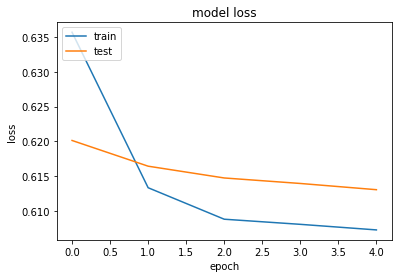

In [92]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [93]:
movie_df = movies.copy()

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 266
Movies with high ratings from user
--------------------------------
Braveheart (1995) : Action|Drama|War
Ref, The (1994) : Comedy
Heathers (1989) : Comedy
Ronin (1998) : Action|Crime|Thriller
Summer of Sam (1999) : Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Rear Window (1954) : Mystery|Thriller
Mary Poppins (1964) : Children|Comedy|Fantasy|Musical
Secrets & Lies (1996) : Drama
Raging Bull (1980) : Drama
Boot, Das (Boat, The) (1981) : Action|Drama|War
Graduate, The (1967) : Comedy|Drama|Romance
Femme Nikita, La (Nikita) (1990) : Action|Crime|Romance|Thriller
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Shining, The (1980) : Horror
Batman Begins (2005) : Action|Crime|IMAX
